In [97]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from typing import List, Optional, Callable, Tuple
from numpy import random
import itertools
import math
import statistics
from tabulate import tabulate
import time
import joblib
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import mean_absolute_error as mae_score
from sklearn.metrics import mean_absolute_percentage_error as mape_score
from sklearn_genetic import GASearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# from sklearn_genetic.space import Categorical, Integer, Continuous

from space import Space
from helper import *

<font size = 6> Genetic algo with Adaptive Mutation</font>


Fitness based adaptive Mutation<br>
https://neptune.ai/blog/adaptive-mutation-in-genetic-algorithm-with-python-examples<br>
https://www.atlantis-press.com/article/7393.pdf

Rank based adaptive mutation <br>
https://arxiv.org/pdf/2104.08842

A good crossover operator for real encoding was proposed by K. Deb in 1995. Here is the paper: http://www.complex-systems.com/pdf/09-2-2.pdf

Parameters 
1. Param Grid: Given
2. Genome: One combination of Param Grid
3. Population: All combinations of Param Grid considered

Functions
1. Genetic Representation of Genome, Population (solutions)
2. Generating new solutions
3. Fitness Value functions: MSE, MAE, etc
4. Elitism/Selection Function: Choose which Genome to undergo CrossOver, can use python's choice function, weight = Fitness Value
5. Cross over Function
6. Mutation Algo: Usually mutation rate is set to 1/L, where L is the length of the bitstring.
7. Evolution Algo

Classes
1. Genome
2. Population
3. GenomSearch
    - GenomSearchCV


Limitations
1. Must be a range
2. cannot pipeline

Future:
1. Allow for more flexible formatting of param_grid
2. Take care of edge cases
3. Convert to binary (maybe faster?)
4. In population.mutation() -> Maybe can update f_max and f_avg as we are mutating, else can try parallel processing

Fitness Function:
Fine-tune the fitness function to better represent the problem's objectives and constraints. A well-designed fitness function guides the algorithm toward the desired solutions.

Constraint Handling:
Implement techniques for handling constraints effectively. Penalization or repair methods can ensure that generated solutions comply with the problem constraints.

Diversity Preservation:
Encourage diversity within the population to prevent premature convergence to local optima. Diversity-preserving techniques, such as crowding or fitness sharing, can help in maintaining a diverse set of solutions.

Hybrid Approaches:
Consider combining the genetic algorithm with other optimization techniques, such as local search or simulated annealing, to explore the search space more effectively.

Parameter Tuning:
Perform parameter tuning using techniques like grid search or genetic algorithms themselves to optimize the genetic algorithm's parameters for your specific problem.

Parallelization:
If your problem domain allows it, consider parallelizing the genetic algorithm to run multiple populations concurrently. This can significantly speed up the search process.




In [98]:
"""
Input example:

param_grid = {'tol': Continuous(1e-2, 1e10, distribution='log-uniform'),
              'alpha': Continuous(1e-5, 2e-5),
              'activation': Categorical(['logistic', 'tanh']),
              'batch_size': Integer(300, 350)
             }

available dtypes:
category, int, float

population = [Genome1, Genome2, Genome3, ...]


need to make one for pipelining so like "PCA__n componenes"

"""

'\nInput example:\n\nparam_grid = {\'tol\': Continuous(1e-2, 1e10, distribution=\'log-uniform\'),\n              \'alpha\': Continuous(1e-5, 2e-5),\n              \'activation\': Categorical([\'logistic\', \'tanh\']),\n              \'batch_size\': Integer(300, 350)\n             }\n\navailable dtypes:\ncategory, int, float\n\npopulation = [Genome1, Genome2, Genome3, ...]\n\n\nneed to make one for pipelining so like "PCA__n componenes"\n\n'

In [99]:
### Config
import os

log_file_dir = "log/"
log_file_name = "log_1"
log_file = log_file_dir + log_file_name + ".txt"

if not os.path.exists(log_file_dir):
    os.makedirs(log_file_dir)
    print("log directory successfully created")




In [100]:
## Global

X_train = None
X_test = None
y_train = None
y_test = None
estimator = None
metric = None
param_grid = None



In [101]:
class Genome():
    def __init__(self, params):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self._estimator = estimator
        self.metric = metric
        self._params = params
        self._fitness = self.calc_fitness(params)
        
    
    @property
    def estimator(self):
        return self._estimator

    @property
    def params(self):
        return self._params

    @property
    def fitness(self):
        return self._fitness

    @params.setter
    def params(self, new_params):
        self._fitness = self.calc_fitness(new_params)
        self._params = new_params


    ## Comparing operators
    def __lt__(self, other):
        # Define custom behavior for "<"
        return self.fitness < other.fitness

    def __le__(self, other):
        # Define custom behavior for "<="
        return self.fitness <= other.fitness

    def __ge__(self, other):
        # Define custom behavior for ">="
        return self.fitness >= other.fitness

    def __eq__(self, other):
        # Define custom behavior for "=="
        return self.fitness == other.fitness

    def __ne__(self, other):
        # Define custom behavior for "!="
        return self.fitness != other.fitness
    
    def __len__(self):
        return len(self.params.keys())
    
    def __repr__(self):
        string = f'(Genome = Params : {self.params}, Fitness : {self.fitness})'
        return string
    
    def extract(self, start, stop = None, step = 1):
        """
        Just for ease of slicing
        
        Parameters
        -----------------
        key: Can be slice object
        """
        if not stop: ## If stop == None, means only want extract one
            return dict([list(self.params.items())[start]])
            
        elif stop > start and stop <= len(self):
            target = dict([list(self.params.items())[i] for i in range(start, stop, step)])
            return target
        else:
            raise IndexError(f"Index out of range.")

    
    def calc_fitness(self, params):
        """
        Parameters
        -------------------
        Takes in 1 genome/set of params
        """

        model = clone(self.estimator)
        model.set_params(**params)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        results = evaluate(self.y_test, y_pred, self.metric)
        model = None

        return results

    
    def mutate(self, param_grid, rate, verbose = False):
        """"
        Mutate one gene

        Parameters
        --------------------
        choices: Param_grid for choosing
        rate: Mutation rate/ Probability of one parameter undergoing mutation

        Returns
        -------------------
        Returns new gene
        """
        if verbose:
            print(f'original: {self}')

        length = len(self)
        choices = list(range(0, length))
        params = self.params.copy()
        keys = list(params.keys())

        for i in choices:
            prob = random.random()
            if prob < rate:   ## If 0 < prob and prob < rate, means falls under the possibility of mutating
                key = keys[i]
                target_val = params[key]
                items = param_grid[key]
                new_target_val = target_val

                if isinstance(items, Categorical):
                    if len(items) == 1:
                        continue
                else:
                    while new_target_val == target_val:     ## Iterate until not the same 
                        new_target_val = items.sample()     ## Ok but i'm not sure if i should do this because sklearn didnt and it
                                                            ## kind of ruins the sampling from a distribution purose

                params[key] = new_target_val
                if verbose:
                    print(f"After mutation: '{key}': '{new_target_val}'")
            else:
                if verbose:
                    print(f'No mutation.')
                continue

        new_gene = Genome(params)

        return new_gene
    


    

In [102]:
class Population():
    def __init__(self, pop_size, population = None):
        self._X_train = X_train
        self._X_test = X_test
        self._y_test = y_test
        self._y_train = y_train
        self._estimator = estimator
        self._param_grid = param_grid
        self._pop_size = pop_size
        self._metric = metric
        
        if not population:  ## If no population
            self._population = self.generate_pop()
        else:
            self._population = population

    @property
    def X_train(self):
        return self._X_train
    
    @property
    def X_test(self):
        return self._X_test
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test

    @property
    def estimator(self):
        return self._estimator
    
    @property
    def population(self):
        return tim_sort(self._population)
    
    @property
    def param_grid(self):
        return self._param_grid
    
    @property
    def pop_size(self):
        return self._pop_size
    
    @property
    def metric(self):
        return self._metric

    @property
    def get_fit(self):
        """
        Helps to get list of fitness values
        """
        fits = []
        for i in self.population:
            fits += [i.fitness]
        return fits


    @population.setter
    def population(self, new_pop):
        self._population = new_pop

    ## Used this only for sorting so it's easier
    def __getitem__(self, key):
        if isinstance(key, int):
            return self.population[key]
        
        elif isinstance(key, slice):
            start, stop, step = key.indices(self.n)
            target = [self.population[i] for i in range(start, stop, step)]
            return target
        else:
            raise TypeError(f"Invalid Argument type. Must be int or slice.")
        
    def __repr__(self):
        string = ""
        for genome in self.population:
            string += f'{genome}\n'
        return string
        
    def copy(self):
        """
        Makes a copy of the current generation
        """
        pop_copy = [genome for genome in self.population]
        return Population(self.param_grid, self.pop_size, pop_copy)
            
    

    
    def calc_avg_fit(self):
        """
        For adaptive Mutation
        """
        fits = self.get_fit
        return statistics.mean(fits)


    def generate_pop(self):
        random.seed(3)
        """
        To initialize population

        Parameters
        --------------
        n: Number of Genomes

        Returns
        ---------------
        None

        """
        pop = []
        for i in range(self.pop_size):
            params = {}
            for key in self.param_grid.parameters:
                params[key] = self.param_grid[key].sample()
            new_genome = Genome(params)
            pop += [new_genome]

        return pop


    def elitism(self, n):
        """
        To choose which n Genomes to bring over to next gen

        Parameters
        ------------------
        n: prop of Genomes, default 0.2 of population

        Returns
        -----------------
        Top n Genomes
        """
        if not 0 < n < 1:
            raise ValueError("n must be between 0 and 1")
        n = round(n*self.pop_size)
        top_n = self.population[0:n]

        return top_n


    def n_cross_over(self, genes, n, nco_rate = 0.5, verbose = False):
        """
        To cross over 2 genomes
        
        Parameters
        ------------------------
        genes: (a,b) Cross over genomes in pop[a] and pop[b]
        n: Number of points to cross over
        verbose: Illustrate parents to genomes
        nco_rate: Cross over rate/ Probability of genes undergoing crossover
            -> If rate = 0: None of the genes can undergo mutation
            -> If rate = 1: All of the genes can undergo mutation
        
        Returns
        ----------------------
        2 Genomes, Crossed over, not in place
        """
        a,b = genes
        a = int(a)
        b = int(b)
        gene1 = self.population[a]
        gene2 = self.population[b]

        len1 = len(gene1)
        len2 = len(gene2)
        if len1 != len2:
            raise ValueError("Genomes must be of same length")
        
        if len1 < 2:
            raise Exception("Too short!")
        
        if n >= len1 -1:
            raise Exception(f"Too much cross-over points. Maximum is {len1-1}.")

        prob = random.random()

        if prob > nco_rate:  
            if verbose:
                print("p value = %.5f is more than %f. No cross over." %(prob, nco_rate))
            return [gene1, gene2]

        choices = list(range(1,len1))
        idx = list(np.random.choice(choices, size = n, replace = False))
        idxs = tim_sort(idx + [0, len1]) 
        sections = n+1
        params3 = {}
        params4 = {}

        for i in range(sections):
            ## Even
            if i%2 == 0:
                params33 = gene1.extract(idxs[i], idxs[i+1])
                params44 = gene2.extract(idxs[i], idxs[i+1])
                
                    
            ## Odd
            else:
                params33 = gene2.extract(idxs[i], idxs[i+1])
                params44 = gene1.extract(idxs[i], idxs[i+1])
            
            params3 = merge_dicts(params3, params33)
            params4 = merge_dicts(params4, params44)
                
        gene3 = Genome(params3)
        gene4 = Genome(params4)

        if verbose:
            print(f'------------Parent Genomes------------\n{gene1}\n{gene2}\n')
            print(f'After {n}-point(s) crossover at index(es) : {idx}\n')
            print(f'------------Children Genomes-------------\n{gene3}\n{gene4}\n')
            print('================================================')

        return [gene3, gene4]


    def selection(self, n, subset = None):
        """"
        Purpose:
        Helps n_cross_over by choosing what 2 genomes to put in
        
        Input:
        'n': Number of parent pairs
        'subset': [low,high) Genes in population to select from eg. gene index 4:7 (exclusive)

        Output:
        List of tuples of indexes: [ (parent1,parent2) ,(parent3, parent4)]
        """
        if not subset:
            low, high = (0, self.pop_size)
            size = self.pop_size
        else:
            low, high = subset
            size = high -low 

        max = math.comb(size, 2)
        if n > max:
            raise ValueError(f'Too much combinations. Maximum is {max}')

        pairs = []
        choices = list(range(low, high))
        fits = self.get_fit[low:high]
        p = [i/sum(fits) for i in fits]

        for i in range(n):
            parent1, parent2 = random.choice(choices, p = p, size = 2, replace = False)
            pairs += [(parent1, parent2)]
        
        return pairs
    
    def fitness_mutation_rate(self, k, f_max, f_avg, f):
        """
        Purpose:
        Fitness-based adaptive mutation

        Input:
        k: (k1,k2) Tuple of 2 for constant, k1,k2 in (0,1)
        f_max: Maximum fitness of population
        f_avg: Average fitness of population
        f: Current fitness value of Genome
        
        Output:
        rate -> int
        """
        k1, k2 = k
        # print(f'k: {k}, f_max; {f_max}, f_avg: {f_avg}, f: {f}')
        
        if f >= f_avg:      ## High quality solution
            rate = k1*( (f_max - f)/(f_max-f_avg) )
        else:               ## Low quality solution
            rate = k2
        return rate

    def rank_mutation_rate(self, p_max, r, n):
        """"
        Purpose:
        Rank-based adaptive mutation
        
        Input:
        p_max: Maximum mutation probability
        r: Rank of chromosome
        n: population size

        Output:
        rate -> int
        """
        p = p_max*( 1- (r-1)/(n-1))
        return p

    def mutation(self, type, params, verbose = False, inplace = True):
        """
        Purpose:
        Randomly select from population without replacement and mutate

        Input:
        type: 'fitneses', 'random', 'rank'
            Default
            - 'fitness' : k = (k1,k2) = (0.05,0.06)
            - 'random': rate = 0.5
            -'rank': p_max = 0.08
        inplace: Mutate on spot

        Output:
        Population with mutated genes, inplace

        Warning:
        Self.population has to be SORTED
        """
        f_max = max(self.get_fit)
        f_avg = self.calc_avg_fit()
        new_pop = []

        subset = self.population
        ## Iterate through all the genome
        for index, gene in enumerate(subset):
            if type == 'fitness':
                k = params['k']
                rate = self.fitness_mutation_rate(k, f_max, f_avg, f = gene.fitness)

            elif type == 'rank':
                r = index
                n = self.pop_size
                p_max = params['p_max']
                rate = self.rank_mutation_rate(p_max, r, n)

            elif type == 'random':
                rate = params['rate']

            else:
                raise ValueError("No such mutation type.")
            
            new_gene = gene.mutate(self.param_grid, rate)
            new_pop += [new_gene]
        
        if inplace:
            self.population = new_pop
            new_pop = self
        else:
            new_pop = Population(self.pop_size, new_pop)

        return new_pop
    
    def best_solution(self):
        return self.population[0]



In [103]:
class GenomeGrid():
    def __init__(self, est, parameters_grid, max_evol = 100, pop_size = 10, mutation_type = "rank", scoring = 'mae', el_prop = 0.2, nco_rate = 0.5, **params):
        """'
        Parameters/Attributes
        -------------------
        est: Model
        param_grid: Parameters
        max_evol: Max evolution
        pop_size: Population size
        mutation_type: 'fitneses', 'random', 'rank'

        optional:
        scoring: Evaluation criteria
        elitism: Prop of population for elitism, default = 0.2
        cross_over_rate/nco_rate: Default = 0.5
        type: 'fitness', 'random', 'rank'
            Default
            - 'fitness' : k = (k1,k2) = (0.05,0.06)
            - 'random': rate = 0.5
            -'rank': p_max = 0.08
        
        """
        global metric, estimator, param_grid
        metric = scoring
        estimator = est
        param_grid = Space(parameters_grid)

        self._estimator = est
        self._param_grid = Space(parameters_grid)
        self._max_evol = max_evol
        self._pop_size = pop_size
        self._mutation_type = mutation_type
        self._metric = scoring
        self._el_prop = el_prop
        self._nco_rate = nco_rate
        self._best_hyperparameters = None
        if mutation_type == 'fitness':
            self._mutation_para = {'k': params.get('k', (0.05, 0.06))}
        elif mutation_type == 'random':
            self._mutation_para = {'rate': params.get('rate', 0.5)}
        elif mutation_type == 'rank':
            self._mutation_para = {'p_max': params.get('p_max', 0.08)}
        else:
            raise Exception('No such mutation type')

    @property
    def estimator(self):
        return self._estimator

    @property
    def param_grid(self):
        return self._param_grid
    
    @property
    def max_evol(self):
        return self._max_evol
    
    @property
    def pop_size(self):
        return self._pop_size
    
    @property
    def mutation_type(self):
        return self._mutation_type
    
    @property
    def metric(self):
        return self._metric

    @property
    def best_model(self):
        best_est = joblib.load('best_estimator.pkl')
        return best_est

    @property
    def best_hyperparameters(self):
        return self._best_hyperparameters

    @property
    def mutation_para(self):
        return self._mutation_para    

    @property
    def nco_rate(self):
        return self._nco_rate

    @property
    def el_prop(self):
        return self._el_prop

    @property
    def pop_size(self):
        return self._pop_size
    
    @property
    def history(self):
        history_log = joblib.load('history.pkl')
        return history_log
    

    @best_hyperparameters.setter
    def best_hyperparameters(self, new):
        self._best_hyperparameters = new



    def split_data(self, X, y):
        """
        To set global X and y data
        """
        global X_train, X_test, y_train, y_test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        
        return


    def fit(self, X, y, early_term = True, early_term_thresh = 0.001, log = True, refit = True, verbose = False):
        """
        Main function to fit
        
        Parameters
        ------------------------
        early_term: terminatate algorithms early, when flag >= 10
        early_term_threshold: Flag += 1
        refit: Auto fit to best model
        verbose: True will also activate log (Write history in the file)

        """
        ## For early term: flag += 1 when change <= thresh
        if early_term:
            flag = 0
        
        start = time.time()
        self.split_data(X,y)

        pop = Population(self.pop_size)

        ## For history
        gen = []
        fitness = []
        fitnessMin = []
        fitnessMax = []

        ## For logging
        if verbose:
            string = "Gen\t\tFitness\t\tFitnessMin\t\tFitnessMax\n"
            with open(log_file, 'w') as log:
                log.write(string)
            print(string)
            

        for i in range(self.max_evol):

            ## Early termination
            if early_term:
                if flag >= 10:
                    break

            ## Elitism: Choose top t
            top_t = pop.elitism(self.el_prop)
            parent_pairs = self.pop_size - len(top_t)

            ## Selection: Make a list of tuple pairs for crossover from subset
            parent_pairs = pop.selection(parent_pairs)

            ## Cross Over subset
            children = []
            for pair in parent_pairs:
                child = pop.n_cross_over(pair, 1, self.nco_rate, verbose)
                children += child
            
            pop = top_t + children
            pop = Population(self._pop_size, pop)
            
            ## Mutate everything, including those carried over by elitism
            pop.mutation(self.mutation_type, self.mutation_para, verbose = verbose)

            ## For log/History
            mini = pop.get_fit[0]
            maxi = pop.get_fit[-1]
            avg = pop.calc_avg_fit()
            
            gen.append(i)
            fitness.append(avg)
            fitnessMin.append(mini)
            fitnessMax.append(maxi)

            if early_term:
                if i >= 1:
                    if abs( avg - fitness[-1] ) < early_term_thresh:
                        flag += 1
                    else:
                        flag = 0

        
            if verbose:
                string = f'{i}\t{avg}\t{mini}\t{maxi}\n'
                with open(log_file, "a") as log:
                    log.write(string)
                print(string)

                
        
        best = pop.best_solution()
        self.best_hyperparameters = best.params
        history = {'gen':gen, 'fitness':fitness, 'FitnessMin': fitnessMin, 'fitnessMax': fitnessMax}
        joblib.dump(history, 'history.pkl')

        if refit:
            model = clone(self.estimator)
            model.set_params(**best.params)
            model.fit(X_train, y_train)
            joblib.dump(model, 'best_estimator.pkl')

        end = time.time()
        self.time_taken = end-start
        
        return best



    def compare(self, param_grid_search, param_grid_ga, plot = True):
        if not self.time_taken:
            raise Exception('Model not fitted yet!')
        
        pred = self.best_model.predict(X_test)
        cur_result = round(evaluate(y_test, pred, metric),5)

        ## sklearn's Genetic Algo
        start = time.time()
        model_ga = clone(self.estimator)
        model_ga = GASearchCV(estimator = model_ga, param_grid = param_grid_ga, cv = 3, verbose = False, scoring = 'neg_mean_absolute_error', population_size = self.pop_size, generations = self.max_evol-1)
        model_ga.fit(X_train, y_train)
        end= time.time()
        time_ga = end - start

        pred = model_ga.predict(X_test)
        ga_result = round(evaluate(y_test, pred, self.metric),5)

        ## sklearn's GridSearch
        start = time.time()
        model_gs = clone(self.estimator)
        model_gs = GridSearchCV(estimator = model_gs, param_grid = param_grid_search, scoring = 'neg_mean_absolute_error', return_train_score = True)
        model_gs.fit(X_train, y_train)
        end = time.time()
        time_gs = end - start
        

        pred = model_gs.predict(X_test)
        gs_result = evaluate(y_test, pred, metric)

        table = [["         ", "My GridSearch", "sklearn GASearch", "GridSearchCV"],
                 ["Test " + self.metric, cur_result, ga_result, gs_result],
                 ["Time Taken", self.time_taken, time_ga, time_gs]]

        print(tabulate(table, headers = "firstrow", tablefmt="github"))

        print(f'My Gridsearch: {self.best_hyperparameters}\nSklearn GASearchCV: {model_ga.best_params_}\nSklearn GridSearchCV: {model_gs.best_params_}\n')

        if plot:
            y1 = self.history['fitness']
            y2 = [ abs(i) for i in model_ga.history['fitness'] ]
            y3 = [abs(i) for i in list(model_gs.cv_results_['mean_train_score'])]

            x = list(range(self.max_evol))
            n = min(len(y2), len(y3))

            plt.plot(x[:n], y3[:n], label = "Sklearn GridSearchCV")
            plt.plot(x, y2, label = "Sklearn GASearchCV" )
            plt.plot(x[:len(y1)], y1, label = "My GASearch")
            

            # if len(y3) < len(y2):
            #     plt.plot(x[:len(y3)], y3, label = "Sklearn GridSearchCV")
            # else:
            #     avges = []
            #     for i in range(0, len(y3), 20):
            #         grp = y3[i:i+20]
            #         avges += statistics.mean(grp)
            #     plt.plot()

            plt.xlabel('Generations')
            plt.ylabel('Fitness')
            plt.title('Rate of convergence to optimal with Train data')

            plt.legend()
            plt.show()

        return 






In [104]:
## Test

param_grid = {
    'a': {'range': [1,10], 'dtype' : 'int'},
    'b': {'range': [1,10], 'dtype' : 'int'},
    'c': {'range': [1,10], 'dtype' : 'int'},
    'd': {'range':['A','B','C'], 'dtype' : 'category'}
}

## Wrong or edge cases
edge_cases = {  
    'd': {'range': [1,2], 'dtype': 'int'},      ## Convert to below
    'e': {'range': [1], 'dtype' : 'int'},
    'd': {'range': [1,2], 'dtype': 'float'}
}

wrong_cases = {
    'a': {'range': [], 'dtype':'int'},
    'b': {'range': [1,1], 'dtype': 'int'},
    'c': {'range': [1,2,3], 'dtype': 'category'}
}


In [105]:
from space import Categorical, Integer, Continuous, Space
# from sklearn_genetic.space import Categorical, Integer, Continuous

param_grid = {
            'kernel': {'range' :['linear','poly'], 'dtype': 'category'},
            'C':{'range' : [0, 1], 'dtype': 'float'},
            'gamma': {'range': [0,1], 'dtype': 'float'}
            }

param_grid_ga = {'kernel': Categorical(['linear','poly']),
                        'C': Continuous(0,1),
                        'gamma': Continuous(0,1)}

param_grid_search = {'kernel': ['linear','poly'],

                     'C': [random.uniform(0,1) for i in range(10)],
                     'gamma': [random.uniform(0,1) for i in range(10)]}

# Categorical(['linear','poly']).sample()

In [106]:
from sklearn import svm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


df = load_iris()
X = df.data
y = df.target


model = svm.SVC()

pop = GenomeGrid(model, param_grid_ga, mutation_type = 'rank')

In [107]:
pop.fit(X,y,log = False, verbose = False)

this is the NEW POP [(Genome = Params : {'kernel': 'linear', 'C': 0.5507979025745755, 'gamma': 0.7081478226181048}, Fitness : 0.03333333333333333), (Genome = Params : {'kernel': 'poly', 'C': 0.12132858120521606, 'gamma': 0.5693113274346809}, Fitness : 0.03333333333333333), (Genome = Params : {'kernel': 'poly', 'C': 0.8962930889334381, 'gamma': 0.12558531046383625}, Fitness : 0.03333333333333333), (Genome = Params : {'kernel': 'poly', 'C': 0.24788829722603556, 'gamma': 0.09355149746544533}, Fitness : 0.03333333333333333), (Genome = Params : {'kernel': 'linear', 'C': 0.029876210878566956, 'gamma': 0.4568332243947111}, Fitness : 0.06666666666666667), (Genome = Params : {'kernel': 'linear', 'C': 0.21557700841491878, 'gamma': 0.35390507188629283}, Fitness : 0.03333333333333333), (Genome = Params : {'kernel': 'poly', 'C': 0.5908628174163508, 'gamma': 0.023981882377165364}, Fitness : 0.1), (Genome = Params : {'kernel': 'linear', 'C': 0.9736482669357392, 'gamma': 0.40236064355895806}, Fitness 

(Genome = Params : {'kernel': 'linear', 'C': 0.7710019471158831, 'gamma': 0.41361899633413035}, Fitness : 0.03333333333333333)

In [108]:
def generate():
    from sklearn_genetic.space import Categorical, Integer, Continuous
    param_grid_ga_2 = {'kernel': Categorical(['linear','poly']),
                            'C': Continuous(0,1),
                            'gamma': Continuous(0,1)}

    return param_grid_ga_2

g = generate()

|             |   My GridSearch |   sklearn GASearch |   GridSearchCV |
|-------------|-----------------|--------------------|----------------|
| Test mae    |         0.03333 |            0.03333 |      0.0333333 |
| Time Taken  |         1.01818 |           16.5517  |      2.81915   |
My Gridsearch: {'kernel': 'linear', 'C': 0.7710019471158831, 'gamma': 0.41361899633413035}
Sklearn GASearchCV: {'kernel': 'linear', 'C': 0.782148813453277, 'gamma': 0.6405014895562051}
Sklearn GridSearchCV: {'C': 0.6909634995100605, 'gamma': 0.496558761301648, 'kernel': 'linear'}



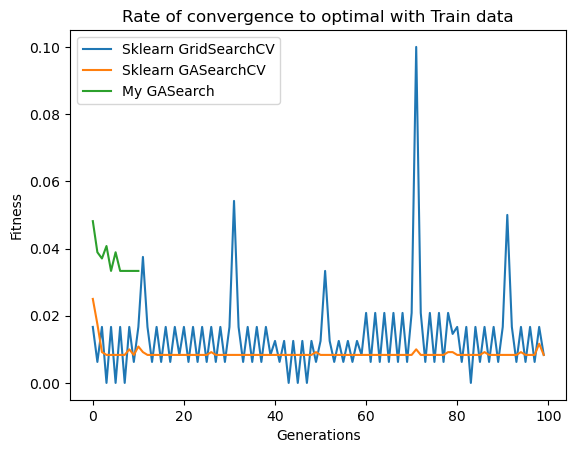

In [109]:
pop.compare(param_grid_search, g)